In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    roc_auc_score
)

# import shap


In [2]:
def evaluate_performance(all_target, predicted, toplot=True,silent=True, save=None):
    all_target = np.array(all_target)
    predicted = np.array(predicted)
    fpr, tpr, thresholds = roc_curve(all_target, predicted)
    roc_auc = auc(fpr, tpr)
    ks = max(tpr-fpr)
    maxind = (tpr-fpr).argmax()

    event_rate = sum(all_target) / 1.0 / all_target.shape[0]
    cum_total = tpr * event_rate + fpr * (1-event_rate)
    minind, = np.nonzero(np.ravel(abs(cum_total - event_rate) == min(abs(cum_total - event_rate))))
    if minind.shape[0] > 0:
        minind = minind[0]

    if toplot:
        # KS plot
        plt.figure(figsize=(26,6))
        plt.subplot(1,4,1)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], color='k', linestyle='--', linewidth=2)
        plt.title('KS='+str(round(ks,3))+ ' AUC='+str(round(roc_auc,3)), fontsize=20)
        plt.plot([fpr[maxind], fpr[maxind]], [fpr[maxind], tpr[maxind]], linewidth=4, color='r')
        plt.plot([fpr[minind]], [tpr[minind]], 'k.', markersize=10)

        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False positive', fontsize=20); plt.ylabel('True positive', fontsize=20);
        if not silent:
            print ('KS=' + str(round(ks,3)) + ', AUC=' + str(round(roc_auc,3)) +', N='+str(predicted.shape[0]))
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(tpr[minind],3)) + ', ' + str(int(round(tpr[minind]*event_rate*all_target.shape[0]))) + ' out of ' + str(int(round(event_rate*all_target.shape[0]))) ) 
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(fpr[minind],3)) + ', ' + str(int(round(fpr[minind]*(1.0-event_rate)*all_target.shape[0]))) + ' out of ' + str(int(round((1.0-event_rate)*all_target.shape[0]))))  
    
        # Score distribution score
        plt.subplot(1,4,2)
        #print predicted.columns
        plt.hist(predicted, bins=20)
        plt.axvline(x=np.mean(predicted), linestyle='--')
        plt.axvline(x=np.mean(all_target), linestyle='--', color='g')
        plt.title('N='+str(all_target.shape[0])+' Tru='+str(round(np.mean(all_target),3))+' Pred='+str(round(np.mean(predicted),3)), fontsize=20)
        plt.xlabel('Target rate', fontsize=20)
        plt.ylabel('Count', fontsize=20)

        # Score average by percentile
        binnum = 10
        ave_predict = np.zeros((binnum))
        ave_target = np.zeros((binnum))
        indices = np.argsort(predicted)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum):
            startind = i*binsize
            endind = min(predicted.shape[0], (i+1)*binsize)
            ave_predict[i] = np.mean(predicted[indices[startind:endind]])
            ave_target[i] = np.mean(all_target[indices[startind:endind]])
        
        plt.subplot(1,4,3)
        plt.plot(ave_predict, 'b.-', label='Prediction', markersize=5)
        plt.plot(ave_target, 'r.-', label='Truth', markersize=5)
        # plt.legend(loc='lower right')
        plt.xlabel('Percentile', fontsize=20)
        plt.ylabel('Target rate', fontsize=20)
        plt.title("Sloping", fontsize=20)
        if not silent:
            print ('Ave_target: ' + str([round(i,4) for i in ave_target]))
            print ('Ave_predicted: ' + str(ave_predict))
            
            
        count_predict = np.zeros((binnum+1))
        count_target = np.zeros((binnum+1))
        indices = np.argsort(predicted,)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum+1):
            endind = min(predicted.shape[0], (i)*binsize)
            count_predict[i] = np.sum(all_target)-np.sum(all_target[indices[0:endind]])
            count_target[i] = np.sum(all_target)
        
        count_predict = list(count_predict)
        count_predict.reverse()
        ave_predict = list((count_predict/count_target))

        top_20_len = int(len(predicted)/5)
        top_20_ratio = np.sum(all_target[indices[-top_20_len:]])*100.0/np.sum(all_target)
        
        btm_10_len = int(len(predicted)/10)
        btm_10_ratio = np.sum(all_target[indices[:btm_10_len]])*100.0/np.sum(all_target)
        
        plt.subplot(1,4,4)
        plt.plot(ave_predict, 'b.-', markersize=5)
        # plt.legend(loc='up right')
        plt.xlabel('Top score bin(bad-->good)', fontsize=20)
        plt.ylabel('Capture rate', fontsize=20)
        plt.title("TOP20:{0}% , BTM10:{1}%".format(round(top_20_ratio,2),round(btm_10_ratio,2)), fontsize=20)
        if not silent:
            print ('#True: ' + str([int(i) for i in count_predict]))
            print ('%True: ' + str([round(i,2) for i in ave_predict]))            
            
        if save is not None:
            plt.savefig(save)
            
        plt.show()

    return ks


def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## Feature Selection

In [3]:
train_data = pd.read_csv("./../data/processed/train_processed.csv")
test_data = pd.read_csv("./../data/processed/test_processed.csv")

print(train_data.shape, test_data.shape)

## Preprocess the target
def handle_target(x, thresh=3.5):
    
    if x < thresh:
        return 0
    else:
        return 1
    
train_data["Stars"] = pd.to_numeric(train_data["Stars"], errors='coerce').fillna(-1).astype(float).apply(handle_target)
test_data["Stars"] = pd.to_numeric(test_data["Stars"], errors='coerce').fillna(-1).astype(float).apply(handle_target)


X_train, y_train = train_data.drop(["Stars"], axis=1), train_data["Stars"]
X_test, y_test = test_data.drop(["Stars"], axis=1), test_data["Stars"]


(3160, 648) (790, 648)


/Users/tuanzai/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (647) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pipe_rfe_ridgecv = RFECV(Ridge(), cv=2)
pipe_rfe_ridgecv.fit(X_train, y_train)

display(mean_std_cross_val_scores(pipe_rfe_ridgecv, X_train, y_train, return_train_score=True))

In [ ]:
# pipe_rfe_ridgecv.get_feature_names_out(), pipe_rfe_ridgecv.n_features_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1, perc=90)
feat_selector.fit(X_train.values, y_train)

In [ ]:
feature_ranks = pd.DataFrame([X_train.columns, feat_selector.ranking_, feat_selector.support_]).T
feature_ranks.columns = ["feature", "rank", "keep"]
feature_ranks["keep_ridge"] = feature_ranks.feature.apply(lambda x: True if x in pipe_rfe_ridgecv.get_feature_names_out() else False)
feature_ranks = feature_ranks.sort_values("rank")
feature_ranks

,feature,rank,keep,keep_ridge
646,yum,1,True,True
377,Brand_Sainsbury's,1,True,True
572,Country_Netherlands,1,True,True
575,Country_Pakistan,1,True,True
577,Country_Philippines,1,True,False
...,...,...,...,...
296,Brand_Nakaya Shouten,522,False,False
442,Brand_Tabate,522,False,False
145,Brand_Haogemen,522,False,True
148,Brand_Happy Noodle,522,False,True


In [ ]:
features_1 = feature_ranks["feature"].to_list()
√ = feature_ranks[feature_ranks["keep"] == True]["feature"].to_list()
features_3 = feature_ranks[(feature_ranks["keep"] == True) | (feature_ranks.head(300)["keep_ridge"] == True)]["feature"].to_list()

len(features_1), len(features_2), len(features_3), 

/var/folders/0t/2l8b0vvj0pg0_299f5hf11g00000gp/T/ipykernel_33155/2221408163.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_3 = feature_ranks[(feature_ranks["keep"] == True) | (feature_ranks.head(300)["keep_ridge"] == True)]["feature"].to_list()


(647, 77, 227)

## Model Selection

In [ ]:
list_feature = [x for x in train_data if x != "Stars"]

X_train, y_train = train_data[list_feature], train_data["Stars"]
X_test, y_test = test_data[list_feature], test_data["Stars"]


class_weights = (1 - y_train.value_counts() / len(y_train)).tolist()
models={
"LogisticRegression": LogisticRegression(random_state=123, class_weight='balanced'),
"RandomForest": RandomForestClassifier(random_state=123, class_weight='balanced'),
"SVC": SVC(random_state=123, class_weight='balanced'),
"CatBoost": CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights)
}



In [ ]:
for features_list in [features_1, features_2, features_3]:

    rst_df=[]
    for model in models:
        print(model)
        tmp_df=pd.DataFrame(mean_std_cross_val_scores(models[model], X_train[features_list], y_train, scoring="roc_auc",
                                                      return_train_score=True, cv=5), columns=[model+"_"+str(len(features_list))])
        rst_df.append(tmp_df)

    rst_df=pd.concat(rst_df, axis=1)
    display(rst_df.T)

# y_prediction = lr.predict_proba(X_test)

# evaluate_performance(y_train, lr.predict_proba(X_train[features_1])[:, 1])

# evaluate_performance(y_test, lr.predict_proba(X_test[features_1])[:, 1])

LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression_647,0.381 (+/- 0.097),0.014 (+/- 0.007),0.711 (+/- 0.017),0.844 (+/- 0.003)
RandomForest_647,0.981 (+/- 0.059),0.033 (+/- 0.002),0.687 (+/- 0.024),0.996 (+/- 0.001)
SVC_647,1.810 (+/- 0.094),0.604 (+/- 0.008),0.712 (+/- 0.014),0.933 (+/- 0.003)
CatBoost_647,2.150 (+/- 0.093),0.078 (+/- 0.090),0.686 (+/- 0.016),0.837 (+/- 0.006)


LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression_77,0.048 (+/- 0.011),0.004 (+/- 0.001),0.687 (+/- 0.016),0.729 (+/- 0.005)
RandomForest_77,0.356 (+/- 0.041),0.023 (+/- 0.002),0.637 (+/- 0.025),0.967 (+/- 0.001)
SVC_77,0.416 (+/- 0.009),0.265 (+/- 0.008),0.681 (+/- 0.021),0.858 (+/- 0.004)
CatBoost_77,1.157 (+/- 0.141),0.007 (+/- 0.001),0.692 (+/- 0.023),0.815 (+/- 0.005)


LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression_227,0.085 (+/- 0.032),0.005 (+/- 0.001),0.737 (+/- 0.017),0.807 (+/- 0.003)
RandomForest_227,0.508 (+/- 0.038),0.025 (+/- 0.001),0.675 (+/- 0.026),0.985 (+/- 0.001)
SVC_227,0.675 (+/- 0.015),0.256 (+/- 0.009),0.727 (+/- 0.019),0.897 (+/- 0.003)
CatBoost_227,1.345 (+/- 0.166),0.013 (+/- 0.001),0.702 (+/- 0.023),0.821 (+/- 0.005)


In [ ]:
# lr = LogisticRegression()
# lr.fit(X_train[features_2], y_train)

# y_prediction = lr.predict_proba(X_test[features_2])

# evaluate_performance(y_train, lr.predict_proba(X_train[features_2])[:, 1])

# evaluate_performance(y_test, lr.predict_proba(X_test[features_2])[:, 1])

In [ ]:
from catboost import CatBoostClassifier


models={
"LogisticRegression": LogisticRegression(random_state=123, class_weight='balanced'),
"RandomForest": RandomForestClassifier(random_state=123, class_weight='balanced'),
"SVC": SVC(random_state=123, class_weight='balanced'),
"CatBoost": CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights)
}


rst_df=[]
for model in models:
    print(model)
    tmp_df=pd.DataFrame(mean_std_cross_val_scores(models[model], X_train[features_2], y_train, return_train_score=True, cv=5), columns=[model])
    rst_df.append(tmp_df)

rst_df=pd.concat(rst_df, axis=1)
rst_df.T

LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression,0.316 (+/- 0.299),0.004 (+/- 0.001),0.641 (+/- 0.018),0.662 (+/- 0.010)
RandomForest,0.459 (+/- 0.090),0.030 (+/- 0.011),0.702 (+/- 0.021),0.903 (+/- 0.005)
SVC,0.455 (+/- 0.028),0.295 (+/- 0.043),0.662 (+/- 0.022),0.768 (+/- 0.015)
CatBoost,1.282 (+/- 0.193),0.006 (+/- 0.001),0.761 (+/- 0.005),0.780 (+/- 0.002)


### Hyper parameter

In [ ]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform


pipe_cat = CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights)

param_grid = {
    "learning_rate": np.linspace(0,0.2,5),
    "max_depth": randint(3, 7),
    "n_estimators": [400, 500, 600, 700, 800],
    
}


rscv = RandomizedSearchCV(pipe_cat, param_grid, scoring='accuracy', cv=5, return_train_score=True)

rscv.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fbd2c75d0d0>,
                   param_distributions={'learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbd2c75da60>,
                                        'n_estimators': [400, 500, 600, 700,
                                                         800]},
                   scoring='accuracy')

In [ ]:
print("Best hyperparameter values: ", rscv.best_params_)
print("Best score: %0.3f" % (rscv.best_score_))
rst = pd.DataFrame(rscv.cv_results_).sort_values('rank_test_score')[
        ['rank_test_score', 'mean_test_score','param_max_depth', 'param_learning_rate', 'param_n_estimators',]
        ].set_index("rank_test_score").sort_index().T

rst


Best hyperparameter values:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 600}
Best score: 0.763


rank_test_score,1,2,3,3,5,6,7,8,9,10
mean_test_score,0.762975,0.762658,0.761076,0.761076,0.760443,0.758544,0.758228,0.757595,0.757595,0.756329
param_max_depth,5,6,4,4,5,3,6,6,5,5
param_learning_rate,0.2,0.2,0.2,0.2,0.15,0.15,0.05,0.1,0.1,0.05
param_n_estimators,600,400,800,800,500,600,500,600,700,400


### Other Metrics

In [ ]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary

pipe_cat = CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights, **rscv.best_params_)

scores = cross_validate(
    pipe_cat, X_train, y_train, return_train_score=True, scoring=scoring
)

display(pd.DataFrame(scores))

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,1.281707,0.050992,0.759494,0.857595,0.857143,0.912959,0.966102,1.0,0.770270,0.839858
1,1.431705,0.055049,0.750000,0.854826,0.850662,0.911417,0.953390,1.0,0.767918,0.837251
2,1.299790,0.046493,0.759494,0.843750,0.856874,0.905298,0.963983,1.0,0.771186,0.826982
3,1.178657,0.043380,0.772152,0.846519,0.864407,0.906820,0.972458,1.0,0.777966,0.829525
4,1.104206,0.038327,0.773734,0.848101,0.864967,0.907692,0.970339,1.0,0.780239,0.830986


In [ ]:
pipe_cat = CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights, **rscv.best_params_)

pipe_cat.fit(X_train, y_train)

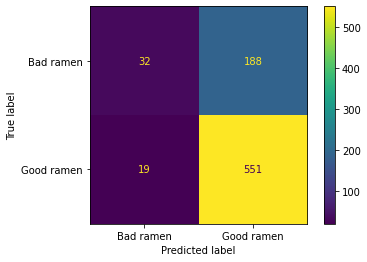

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0

cm = ConfusionMatrixDisplay.from_estimator(
    pipe_cat, X_test, y_test, values_format="d", display_labels=["Bad ramen", "Good ramen"]
)

cm

In [ ]:
scoring_dict = {
    "accuracy": accuracy_score,
    "f1": f1_score,
    "recall": precision_score,
    "precision": recall_score,
}

y_test_hat = pipe_cat.predict(X_test)
y_train_hat = pipe_cat.predict(X_train)

heads, metrics = [], []
for i in scoring_dict:
    for j in [ "test", "train",]:
        if j == "train":
            y = y_train
            y_hat = y_train_hat
        else:
            y = y_test
            y_hat = y_test_hat
            
        heads.append(j+"_"+i)
        metrics.append(scoring_dict[i](y_hat, y))
        
df = pd.DataFrame([metrics], columns=heads)
df



,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.737975,0.841139,0.841864,0.903868,0.966667,1.0,0.745602,0.824598


In [ ]:
print(
classification_report(
    y_test, pipe_cat.predict(X_test), target_names=["Bad ramen", "Good ramen"]
)
)


              precision    recall  f1-score   support

   Bad ramen       0.63      0.15      0.24       220
  Good ramen       0.75      0.97      0.84       570

    accuracy                           0.74       790
   macro avg       0.69      0.56      0.54       790
weighted avg       0.71      0.74      0.67       790



### Coefficients

In [ ]:
import shap

ImportError: Numba needs NumPy 1.20 or less

In [ ]:
new_columns = pipe_rfe_ridgecv[0].get_feature_names_out()

coef_df = pd.DataFrame({"coef": pipe_rfe_ridgecv[-1].coef_[0], "vars": new_columns})
coef_df["coef_abs"] = abs(coef_df["coef"])

In [ ]:
coef_df.sort_values("coef_abs", ascending=False).head(20)

,coef,vars,coef_abs
132,1.728120,Brand_Samyang Foods,1.728120
64,-1.710197,Brand_Knorr,1.710197
191,-1.557720,Country_Canada,1.557720
121,-1.488140,Brand_Ripe'n'Dry,1.488140
206,1.483626,goreng,1.483626
204,1.462231,Country_Singapore,1.462231
68,-1.451897,Brand_Koyo,1.451897
25,1.395956,Brand_Dragonfly,1.395956
201,-1.359974,Country_Netherlands,1.359974
23,-1.342896,Brand_Doll,1.342896


In [ ]:
print("Like variables")

coef_df.sort_values("coef", ascending=False).head(20).to_csv("./../results/Top_20_Good_features.csv", index=False)

coef_df.sort_values("coef", ascending=False).head(20)


Like variables


,coef,vars,coef_abs
132,1.728120,Brand_Samyang Foods,1.728120
206,1.483626,goreng,1.483626
204,1.462231,Country_Singapore,1.462231
25,1.395956,Brand_Dragonfly,1.395956
165,1.283582,Brand_Tseng Noodles,1.283582
84,1.275756,Brand_Master Kong,1.275756
198,1.265622,Country_Malaysia,1.265622
182,1.258166,Brand_Yamachan,1.258166
57,1.241617,Brand_Kabuto Noodles,1.241617
109,1.133410,Brand_Paldo,1.133410


In [ ]:
print("Hate variables")

coef_df.sort_values("coef", ascending=True).head(20).to_csv("./../results/Top_20_Bad_features.csv", index=False)

coef_df.sort_values("coef", ascending=True).head(20)


Hate variables


,coef,vars,coef_abs
64,-1.710197,Brand_Knorr,1.710197
191,-1.557720,Country_Canada,1.557720
121,-1.488140,Brand_Ripe'n'Dry,1.488140
68,-1.451897,Brand_Koyo,1.451897
201,-1.359974,Country_Netherlands,1.359974
23,-1.342896,Brand_Doll,1.342896
137,-1.242377,Brand_Shirakiku,1.242377
32,-1.185306,Brand_Four Seas,1.185306
12,-1.151730,Brand_Chewy,1.151730
7,-1.145100,Brand_Baijia,1.145100
